In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob, os
import pandas as pd
from dask import delayed
from dask.distributed import Client
from solardatatools import DataHandler
from dask_cloudprovider.aws import EC2Cluster
from sdt_dask.dataplugs.pvdaq_plug import PVDAQPlug

# User defined env variables

In [3]:
PROJECT_PA_NUMBER = os.getenv("PROJECT_PA_NUMBER")
TAGS = {
    "project-pa-number": PROJECT_PA_NUMBER,
    "project": "pvinsight"
}

IMAGE = "slacgismo/dask-sdt-sm-2:latest"

AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
AWS_DEFAULT_REGION = "us-west-2a"
VPC = "vpc-ab2ff6d3" # for us-west-2 

# Import user-defined dataplug

## Pull from PVDAQ

In [4]:
data_plug = PVDAQPlug()

In [5]:
KEYS = [(34, 2011), (35, 2015), (51,2012)] # site ID and year pairs
KEYS

[(34, 2011), (35, 2015), (51, 2012)]

# Create SDT Dask task graph (run in parallel on multiple files)

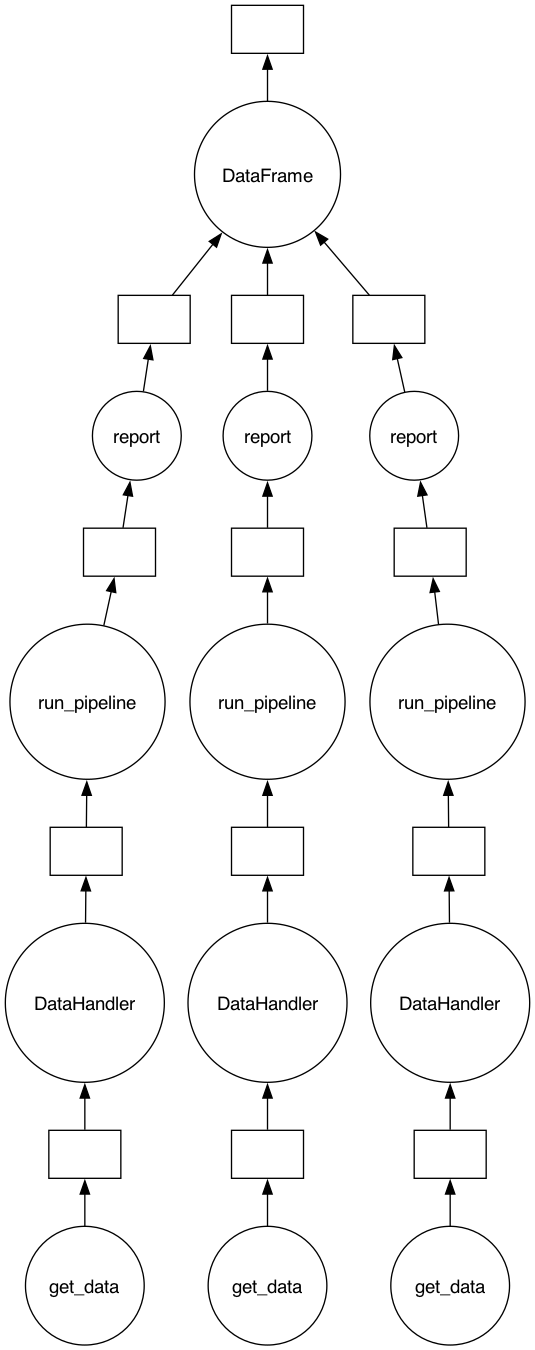

In [6]:
# Define the pipeline run for as single dataset
def run_pipeline(datahandler, solver, solver_convex, verbose=False):
    # Need to call this separately to have it run correctly in task graph 
    # since it doesn't return anything
    datahandler.run_pipeline(solver=solver, solver_convex=solver_convex, verbose=verbose)
    return datahandler


# Call above functions in a for loop over the keys
# and collect results in a DataFrame
reports = []


for key in KEYS:
    
    df = delayed(data_plug.get_data)(key)
    dh = delayed(DataHandler)(df)
    dh_run = delayed(run_pipeline)(dh, solver="OSQP", solver_convex="OSQP", verbose=True)
    report = dh_run.report
    report = delayed(report)(return_values=True, verbose=False)
    reports.append(report)

df_reports = delayed(pd.DataFrame)(reports)

# Visualizing the graph
df_reports.visualize()

# Get User-defined Client
## AWS Fargate


# document/understand: region restrictions for t2.micro (default) and security=False implications
https://github.com/dask/dask-cloudprovider/issues/249

In [7]:
# Instantiate Fargate cluster
cluster = EC2Cluster(
    security=False,
    instance_tags=TAGS,
    docker_image=IMAGE,
    vpc=VPC,
    n_workers=2,
    availability_zone="us-west-2a",
    subnet_id = "subnet-28154263", # need to be in same subzone
    region="us-west-2",
    env_vars={
        'AWS_ACCESS_KEY_ID': AWS_ACCESS_KEY_ID,
        'AWS_SECRET_ACCESS_KEY': AWS_SECRET_ACCESS_KEY
    }
)

Creating scheduler instance
Created instance i-0119e7b04cc2c4718 as dask-be33b9d6-scheduler
Waiting for scheduler to run at 52.12.3.72:8786
Scheduler is running


/opt/miniconda3/envs/pvi-full/lib/python3.10/contextlib.py:142: UserWarning: Creating your cluster is taking a surprisingly long time. This is likely due to pending resources. Hang tight! 
  next(self.gen)


Creating worker instance
Creating worker instance
Created instance i-0a108a4b90fa8e9c4 as dask-be33b9d6-worker-285f6642
Created instance i-00a89da0e0cdfa298 as dask-be33b9d6-worker-785d31cd


In [8]:
client = Client(cluster)
    
client.dashboard_link

/opt/miniconda3/envs/pvi-full/lib/python3.10/site-packages/distributed/client.py:1392: VersionMismatchWarning: Mismatched versions found

+-------------+-----------------+-----------------+---------+
| Package     | Client          | Scheduler       | Workers |
+-------------+-----------------+-----------------+---------+
| cloudpickle | 2.2.1           | 3.0.0           | None    |
| dask        | 2024.2.1        | 2023.11.0       | None    |
| distributed | 2024.2.1        | 2023.11.0       | None    |
| python      | 3.10.13.final.0 | 3.10.11.final.0 | None    |
| tornado     | 6.3.3           | 6.2             | None    |
+-------------+-----------------+-----------------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


'http://52.12.3.72:8787/status'

# Compute pipelines on client

In [11]:
summary_table = client.compute(df_reports)

In [12]:
summary_table

<Future: pending, key: DataFrame-e369d878-9af4-41e0-a9f1-a31b0b84b942>

# Resulting pipeline reports

In [16]:
summary_table.result()

,length,capacity,sampling,quality score,clearness score,inverter clipping,clipped fraction,capacity change,data quality warning,time shift correction,time zone correction
0,1.00000,109.30000,15.0,0.983562,0.498630,True,0.016438,False,False,False,0
1,1.00000,87.70000,15.0,0.989041,0.504110,True,0.016438,False,True,False,0
2,0.70137,4.72341,1.0,0.722656,0.144531,False,0.000000,False,True,False,0


In [16]:
summary_table.result()

,length,capacity,sampling,quality score,clearness score,inverter clipping,clipped fraction,capacity change,data quality warning,time shift correction,time zone correction
0,1.00000,109.30000,15.0,0.983562,0.498630,True,0.016438,False,False,False,0
1,1.00000,87.70000,15.0,0.989041,0.504110,True,0.016438,False,True,False,0
2,0.70137,4.72341,1.0,0.722656,0.144531,False,0.000000,False,True,False,0


In [13]:
client.close()

In [14]:
cluster.close()

Terminated dask-be33b9d6-worker-285f6642 (i-0a108a4b90fa8e9c4)
Terminated dask-be33b9d6-worker-785d31cd (i-00a89da0e0cdfa298)
Terminated dask-be33b9d6-scheduler (i-0119e7b04cc2c4718)
